# Analisis del problema
El objetivo principal es desarrollar un modelo de aprendizaje automático capaz de predecir si una persona está en riesgo de sufrir un accidente cerebrovascular (ACV). Un ACV es una emergencia médica grave que ocurre cuando el suministro de sangre a una parte del cerebro se interrumpe o se reduce, privando al tejido cerebral de oxígeno y nutrientes. Predecir este evento con precisión puede ayudar a los médicos y pacientes a tomar medidas preventivas.


# Entendimiento de los datos

`id`: Identificación única de cada persona. (Tipo: Entero)

`gender`: Género de la persona (Male, Female, Other). (Tipo: Categórico)

`age`: Edad de la persona. (Tipo: Numérico - flotante)

`hypertension`: Si la persona tiene hipertensión (0 = No, 1 = Sí). (Tipo: Binario)

`heart_disease`: Si la persona tiene alguna enfermedad cardíaca (0 = No, 1 = Sí). (Tipo: Binario)

`ever_married`: Si la persona alguna vez estuvo casada (Yes, No). (Tipo: Categórico)

`work_type`: Tipo de trabajo de la persona (Private, Self-employed, Govt_job, Children, Never_worked). (Tipo: Categórico)

`Residence_type`: Tipo de área residencial de la persona (Urban, Rural). (Tipo: Categórico)

`avg_glucose_level`: Nivel promedio de glucosa en sangre de la persona. (Tipo: Numérico - flotante)

`bmi`: Índice de masa corporal (IMC) de la persona. (Tipo: Numérico - flotante)

`smoking_status`: Estado de tabaquismo de la persona (formerly smoked, never smoked, smokes, Unknown). (Tipo: Categórico)

`stroke`: Si la persona ha sufrido un accidente cerebrovascular (0 = No, 1 = Sí). (Tipo: Binario)


# Exploracion de los datos

## Librerias

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Load your dataset
data = pd.read_csv('../datasets/healthcare-dataset-stroke-data.csv')

data['bmi'] = data['bmi'].fillna(data['bmi'].mean())
data.drop(columns='id', inplace=True)

categorical_cols = data.select_dtypes(include=['object']).columns

mapping_dict = {
    "gender": {
        "Male": 1,
        "Female": 0,
        "Other": 2
    },
    "ever_married": {
        "Yes": 1,
        "No": 0
    },
    "work_type": {
        "Private": 0,
        "Self-employed": 1,
        "Govt_job": 2,
        "Children": 3,
        "Never_worked": 4
    },
    "Residence_type": {
        "Urban": 1,
        "Rural": 0
    },
    "smoking_status": {
        "formerly smoked": 1,
        "never smoked": 0,
        "smokes": 2,
        "Unknown": 3
    }
}

for column, mapping in mapping_dict.items():
    data[column] = data[column].map(mapping)

X = data.drop(columns='stroke')
y = data['stroke']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Combine X_train and y_train to resample the data
train_data = pd.concat([X_train, y_train], axis=1)

majority = train_data[train_data.stroke == 0]
minority = train_data[train_data.stroke == 1]

# Upsample the minority class to match the majority class
minority_upsampled = resample(minority,
                              replace=True, 
                              n_samples=len(majority), 
                              random_state=42)

upsampled_data = pd.concat([majority, minority_upsampled])

X_data = train_data.drop(columns='stroke')
y_data = train_data['stroke']


# Modelo de machine learning

In [7]:
# Build and train the Random Forest model on the resampled data
model = RandomForestClassifier(random_state=42)
model.fit(X_data, y_data)

# Make predictions on the test set
y_pred_upsampled = model.predict(X_test)

# Evaluate the model after upsampling the dataset
accuracy_upsampled = accuracy_score(y_test, y_pred_upsampled)
classification_rep_upsampled = classification_report(y_test, y_pred_upsampled)

# Print the results
print(f"Accuracy: {accuracy_upsampled}")
print(classification_rep_upsampled)


Accuracy: 0.9412915851272016
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.48      1533
weighted avg       0.89      0.94      0.91      1533



# Evaluaciones

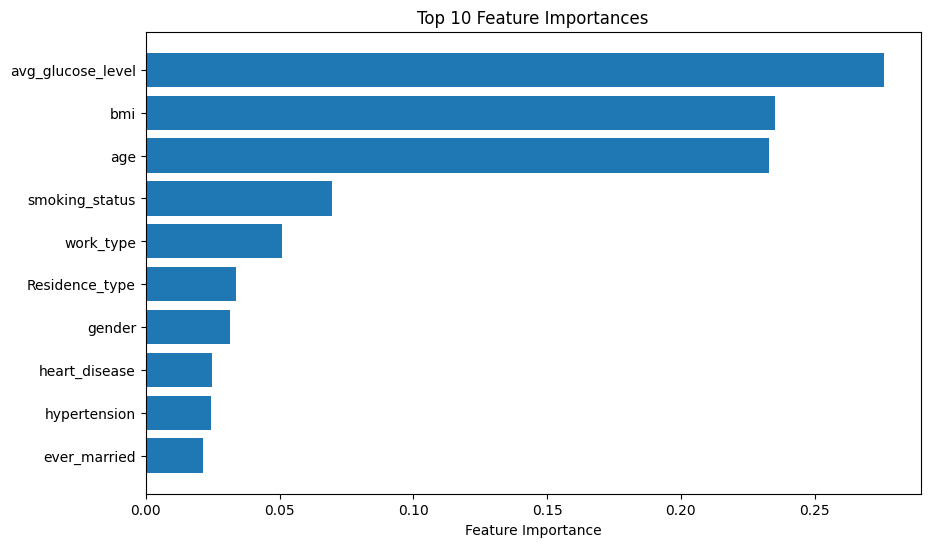

In [8]:

# Get feature importance from the trained Random Forest model
feature_importances = model.feature_importances_

# Get feature names
feature_names = X_data.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Visualize the top 10 important features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.barh(range(10), feature_importances[indices[:10]][::-1], align="center")
plt.yticks(range(10), [feature_names[i] for i in indices[:10]][::-1])
plt.xlabel("Feature Importance")
plt.show()

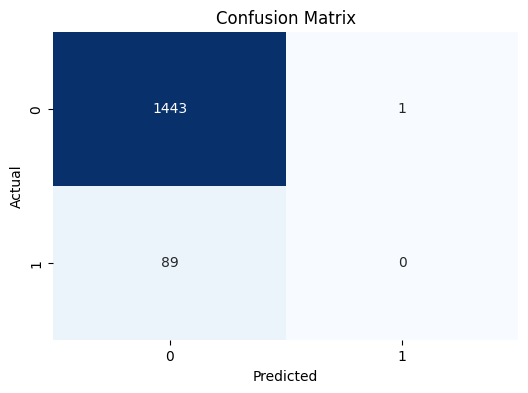

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions using the model
y_pred_upsampled = model.predict(X_test)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_upsampled)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Resultados
El modelo de **Random Forest** con sobremuestreo logró una **precisión global del 93.8%**. Sin embargo, al examinar más de cerca la capacidad del modelo para predecir los casos de **accidente cerebrovascular (ACV)**, observamos que la precisión en la predicción de la clase positiva (personas que tuvieron un ACV) fue baja, con un valor de **20%**, lo que significa que de todas las personas que el modelo predijo que tendrían un ACV, solo el 20% realmente lo sufrieron. Además, el **recall** para esta clase fue solo del **2%**, indicando que el modelo no está capturando adecuadamente los casos de ACV. Esto sugiere que, aunque el modelo funciona bien en la mayoría de los casos, tiene dificultades para identificar correctamente los individuos en riesgo de sufrir un ACV, lo cual es crítico en este tipo de aplicaciones médicas.